<a href="https://colab.research.google.com/github/gizelleguerra/img_processing_practice/blob/main/MNIST_Pytorch_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch Tutorial with MNIST- CNN Version
Tutorial from:
https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

In [5]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy

from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load MNIST Data

In [6]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### EDA

In [7]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [9]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [8]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [10]:
print(test_data.data.size())

torch.Size([10000, 28, 28])


In [14]:
#plotone image
# plt.imshow(train_data.data[2], cmap='gray')
# plt.title('%i' % train_data.targets[2])
# plt.show()

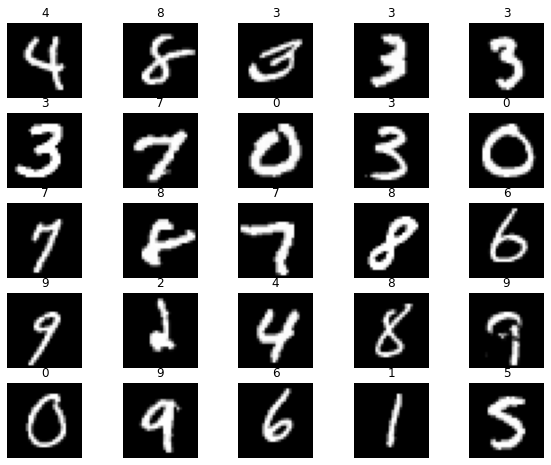

In [13]:
# plot a few images from training set and labels
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Define the Model

In [15]:
from torch.utils.data import DataLoader
#use 1000 instead of 100 for batch size
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f10bab869d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f10ba00b2d0>}

In [16]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [17]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [18]:
# define loss function
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [19]:
# define optimizer
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### Train the Model

In [23]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
               #pass
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1709
Epoch [1/10], Step [200/600], Loss: 0.0674
Epoch [1/10], Step [300/600], Loss: 0.0666
Epoch [1/10], Step [400/600], Loss: 0.0553
Epoch [1/10], Step [500/600], Loss: 0.0693
Epoch [1/10], Step [600/600], Loss: 0.0886
Epoch [2/10], Step [100/600], Loss: 0.0973
Epoch [2/10], Step [200/600], Loss: 0.1352
Epoch [2/10], Step [300/600], Loss: 0.1461
Epoch [2/10], Step [400/600], Loss: 0.1071
Epoch [2/10], Step [500/600], Loss: 0.0467
Epoch [2/10], Step [600/600], Loss: 0.0322
Epoch [3/10], Step [100/600], Loss: 0.0101
Epoch [3/10], Step [200/600], Loss: 0.0210
Epoch [3/10], Step [300/600], Loss: 0.1160
Epoch [3/10], Step [400/600], Loss: 0.0709
Epoch [3/10], Step [500/600], Loss: 0.0476
Epoch [3/10], Step [600/600], Loss: 0.0884
Epoch [4/10], Step [100/600], Loss: 0.0284
Epoch [4/10], Step [200/600], Loss: 0.1037
Epoch [4/10], Step [300/600], Loss: 0.1194
Epoch [4/10], Step [400/600], Loss: 0.0174
Epoch [4/10], Step [500/600], Loss: 0.0504
Epoch [4/10

### Evaluate Model Output on Test Data

In [25]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
          test_output, last_layer = cnn(images)
          pred_y = torch.max(test_output, 1)[1].data.squeeze()
          correct += (pred_y == labels).sum().item()
          total += labels.size(0)
          pass
    accuracy = correct / total
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.98


In [26]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [27]:
actual_number = lbls[:10].numpy()
actual_number

array([0, 7, 2, 6, 2, 1, 1, 6, 1, 1])

In [28]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [0 7 2 6 2 1 1 6 1 1]
Actual number: [0 7 2 6 2 1 1 6 1 1]
